# Sensitivity check for calculation of AAD from hazard return period maps

In this code, we (qualitatively) examine how sensitive the estimation of annual average displacement (AAD) values are (impact.aai_agg) depending on which hazard RP maps that were included. We perform the analysis for floods in 2 countries (PHL, SOM)

In [1]:
# Load country BEM as prep
from climada.util.constants import SYSTEM_DIR
from climada.hazard import TropCyclone, Hazard
from climada.entity.exposures import Exposures
from climada.engine import ImpactCalc
import numpy as np
import os
import copy
from pathlib import Path

os.chdir('/cluster/project/climate/meilers/scripts/displacement/global-displacement-risk') 
import exposure
import vulnerability
import coastal_flood_hazard

# select country here
cntry = 'Somalia'

In [2]:
gdf_bem_subcomps = exposure.gdf_from_bem_subcomps(cntry, opt='full')# filter and apply impf id
gdf_bem_subcomps = gdf_bem_subcomps[gdf_bem_subcomps.valhum>0.001] # filter out rows with basically no population
gdf_bem_subcomps['impf_FL'] = gdf_bem_subcomps.apply(lambda row: vulnerability.DICT_PAGER_FLIMPF_CIMA[row.se_seismo], axis=1)

for col in ['iso3', 'sector', 'valfis']:
    gdf_bem_subcomps.pop(col)

exp = Exposures(gdf_bem_subcomps)
exp.gdf.rename({'valhum': 'value'}, axis=1, inplace=True)
exp.value_unit = 'Pop. count'
exp.gdf['longitude'] = exp.gdf.geometry.x
exp.gdf['latitude'] = exp.gdf.geometry.y
exp.gdf = exp.gdf[~np.isnan(
    exp.gdf.latitude)]  # drop nan centroids

### Load CIMA flood hazard (river)

In [ ]:
HAZ_FOLDER = Path(f'/cluster/work/climate/evelynm/IDMC_UNU/hazard/flood_HM_CIMA/{country}/HISTORICAL/')

haz_files = np.sort([str(file) for file in HAZ_FOLDER.glob('*.tif')])
rp = np.sort(np.array([int(Path(file).stem[-4:]) for file in haz_files]))

Create a dictionary (haz_dict) where each key is a number from 1 to 9 (representing the count of RPs and files) and each value is a Hazard object created using progressively more elements from haz_files and rp up to that number.

In [1]:
haz_dict = {}
for i in range(1, 10):
    # Slice the arrays up to the current index i (i is exclusive, so we use it directly)
    files_slice = haz_files[:i]
    rp_slice = rp[:i]

    # Create the Hazard object
    haz = Hazard.from_raster(
        haz_type=HAZ_TYPE,
        files_intensity=list(files_slice),  # Convert numpy array slice to list
        src_crs='WGS84',
        attrs={
            'unit': 'm',
            'event_id': np.arange(len(files_slice)),
            'frequency': 1 / rp_slice
        }
    )
    haz.intensity = haz.intensity/100
    # Store the Hazard object in the dictionary with i as the key
    haz_dict[i] = haz

NameError: name 'haz_files' is not defined

### Caluclate impacts

#### CIMA/Capra impact functions

In [17]:
impf_set_cima = vulnerability.IMPF_SET_FL_CIMA

In [ ]:
from climada.entity import ImpactFunc, ImpactFuncSet
impf_set_cima_step = ImpactFuncSet()

In [ ]:
# The threshold of building damage after which all people are displaced. Below, no-one is displaced.
building_thes = 0.3 # 55% iDMC v1; CIMA: 30% for Somalia to 60% for other countries. 

for imp_id in impf_set_cima.get_ids(haz_type='FL'):
    impf_set_cima.get_func(fun_id=imp_id)
    y = impf_set_cima.get_func(fun_id=imp_id)[0].intensity
    x = impf_set_cima.get_func(fun_id=imp_id)[0].mdd
    flood_thres = np.interp(building_thes, x, y)
    print('ID: '+str(imp_id)+' - threshold stepfunction: '+str(flood_thres))
    impf_set_cima_step.append(
                ImpactFunc.from_step_impf(
                    intensity=(0,  flood_thres, flood_thres *10),
                    haz_type='FL',
                    impf_id=imp_id,
                    intensity_unit = 'm'
                )
    )

In [18]:
aai_agg_dict = {}
for n, haz in haz_dict.items():
    impf_set = get_TC_step_func(impf_set=impf_set_cf_cima, threshold=thresh, haz_type='FL', unit='m')
    impact = ImpactCalc(exp, impf_set_cima_step, haz).impact()
    aai_agg_dict[n] = impact.aai_agg

2024-05-06 15:45:23,755 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 2123 coordinates.
2024-05-06 15:45:31,108 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 2123 coordinates.
2024-05-06 15:45:38,468 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 2123 coordinates.
2024-05-06 15:45:45,498 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 2123 coordinates.
2024-05-06 15:45:52,519 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 2123 coordinates.
2024-05-06 15:45:59,886 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 2123 coordinates.
2024-05-06 15:46:07,109 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 2123 coordinates.
2024-05-06 15:46:14,306 - climada.util.coordinat

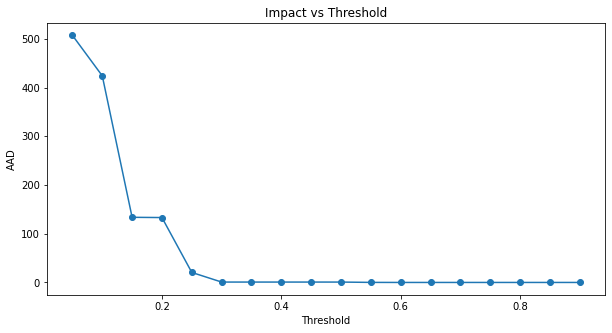

In [19]:
RPs = list(aai_agg_dict_cima.keys())
impacts = list(aai_agg_dict_cima.values())

plt.figure(figsize=(10, 5))
plt.plot(RPs, impacts, marker='o')
plt.title('Impact vs # RP maps')
plt.xlabel('# of RP maps')
plt.ylabel('AAD')
plt.show()